# Movie Recommendation System

# Introduction

In this project, we build a comprehensive Movie Recommendation System using the MovieLens 100K dataset. Recommendation systems are pivotal in modern applications, such as streaming services, to enhance user experience by suggesting personalized content. This system focuses on collaborative filtering techniques, which leverage user behavior (ratings) to identify similarities and generate recommendations.

## Objectives

* Core Task: Implement a user-based collaborative filtering system that recommends movies based on user similarity.
* Approach: Construct a user-item rating matrix, compute similarity scores using cosine similarity, and recommend top-rated unseen movies for a given user.
* Evaluation: Assess performance using Precision at K (P@K), which measures the proportion of recommended items that are relevant (rated highly by the user in a test set).
* Implement item-based collaborative filtering as an alternative approach.
* Explore matrix factorization using Singular Value Decomposition (SVD) for latent factor modeling.
* Include data exploration, visualizations, hyperparameter tuning for SVD, and a comparison of methods to make the project more robust.

## Dataset Overview
The MovieLens 100K dataset (sourced from Kaggle) contains 100,000 ratings from 943 users on 1,682 movies. 

1. Key files include:

* u.data: Ratings data (user_id | movie_id | rating | timestamp) – 100,000 entries.
* u.item: Movie details (movie_id | title | release_date | video_release_date | IMDb_URL | 19 genre flags) – 1,682 entries.
* u.user: User demographics (user_id | age | gender | occupation | zip_code) – 943 entries.
* Pre-split files (e.g., ua.base/ua.test for training/testing).

We will utilize Python with libraries such as Pandas, NumPy, and Scikit-learn. This notebook is designed for execution on Kaggle, where these libraries are pre-installed.

2. Methodology

* Data Loading and Preprocessing: Load ratings and movie data, handle splits for train/test.
* User-Based Collaborative Filtering: Build a pivot table for the user-item matrix, compute similarities, and generate recommendations.
* Item-Based Collaborative Filtering: Transpose the matrix for item similarities.
* Matrix Factorization (SVD): Reduce dimensionality to capture latent factors.
* Evaluation: Use the test set to compute P@K.
* Visualizations: Rating distributions, similarity heatmaps.

# Import Libraries

Import necessary libraries and set up the plots directory for saving visualizations.

In [5]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


%matplotlib inline
sns.set(style="whitegrid")
os.makedirs('plots', exist_ok=True)
os.makedirs('/kaggle/working', exist_ok=True)

# Load Data
Load the MovieLens 100K dataset files and pre-split train/test sets from Kaggle.

In [6]:
ratings = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', sep='\t', 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])

movies = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item', sep='|', 
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + 
                     ['genre_' + str(i) for i in range(19)], encoding='latin-1')

# Load pre-split train/test
train = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/ua.base', sep='\t', 
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])
test = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/ua.test', sep='\t', 
                   names=['user_id', 'movie_id', 'rating', 'timestamp'])

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (90570, 4), Test shape: (9430, 4)


# Filter Low-Activity Users and Movies
Filter out users and movies with fewer than 5 ratings to reduce noise from sparse data.

In [7]:
# Filter users and movies with few ratings to reduce sparsity noise
min_ratings = 5

# Filter on full ratings for consistency
user_counts = ratings['user_id'].value_counts()
active_users = user_counts[user_counts >= min_ratings].index
ratings = ratings[ratings['user_id'].isin(active_users)]

movie_counts = ratings['movie_id'].value_counts()
active_movies = movie_counts[movie_counts >= min_ratings].index
ratings = ratings[ratings['movie_id'].isin(active_movies)]

# Apply same filters to train/test
train = train[train['user_id'].isin(active_users) & train['movie_id'].isin(active_movies)]
test = test[test['user_id'].isin(active_users) & test['movie_id'].isin(active_movies)]

print(f"Filtered Train: {train.shape}, Filtered Test: {test.shape}")

Filtered Train: (89890, 4), Filtered Test: (9397, 4)


# Build User-Item Matrix
Construct the user-item rating matrix and normalize ratings by subtracting user means.

In [18]:
# Build user-item matrix
user_item = train.pivot(index='user_id', columns='movie_id', values='rating')

# Compute global mean for fallback imputation
global_mean = train['rating'].mean()

# Impute missing ratings with user mean
user_means = user_item.mean(axis=1)
user_item_filled = user_item.fillna(user_means, axis=0)  # Fill with user mean
user_item_filled = user_item_filled.fillna(global_mean)  # Fallback to global mean for users with no ratings

# Normalize by z-score for similarity computation
user_std = user_item_filled.std(axis=1).replace(0, 1)  # Avoid division by zero
normalized_ui = user_item_filled.sub(user_means, axis=0).div(user_std, axis=0)

# Data Exploration and Visualizations

## Distribution of Ratings per User
Visualize the distribution of ratings per user to understand data sparsity.

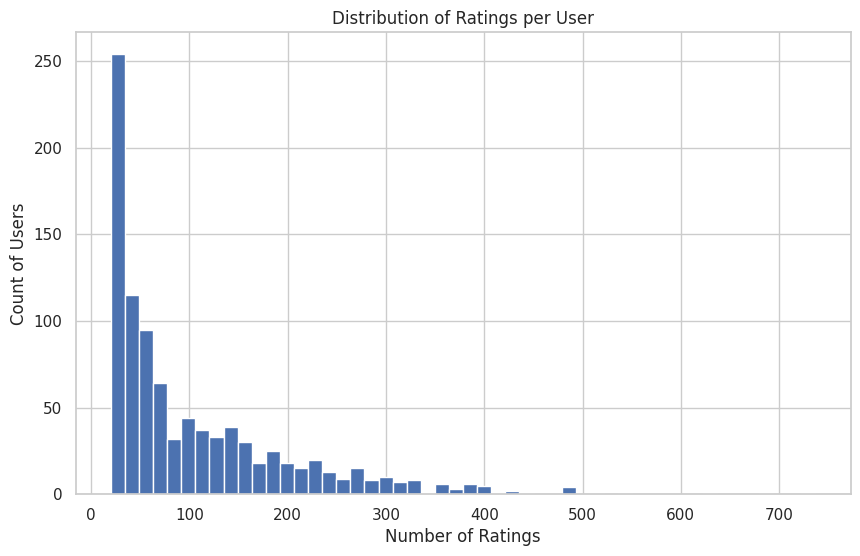

In [10]:
# Data Exploration: Distribution of Ratings per User
plt.figure(figsize=(10,6))
plt.hist(user_counts, bins=50)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.grid(True)
plt.savefig('plots/ratings_per_user.png')
plt.show()

## Distribution of Overall Ratings
Visualize the distribution of all ratings to check for skewness.

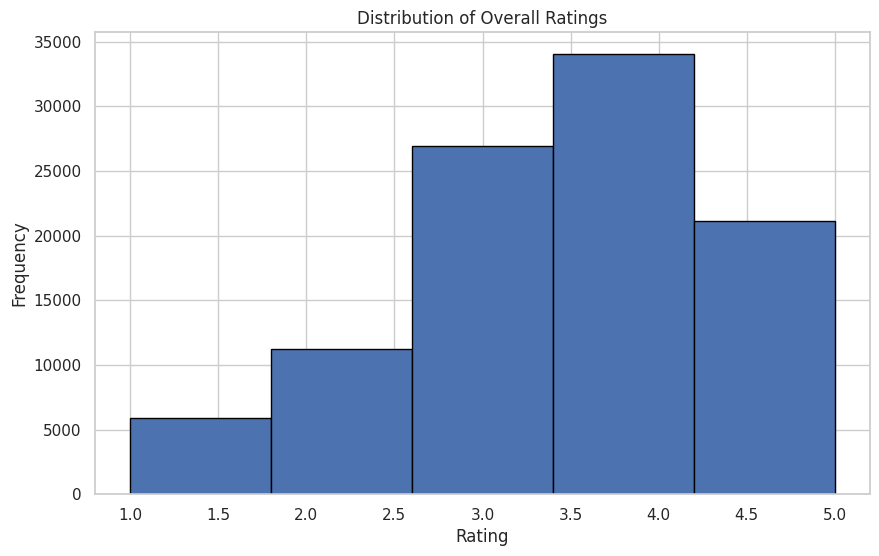

In [25]:
# Data Exploration: Distribution of Overall Ratings
plt.figure(figsize=(10,6))
plt.hist(ratings['rating'], bins=5, edgecolor='black')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('plots/ratings_distribution.png')
plt.show()

## Distribution of Ratings per Movie
Visualize the distribution of ratings per movie to identify popular vs. long-tail movies.

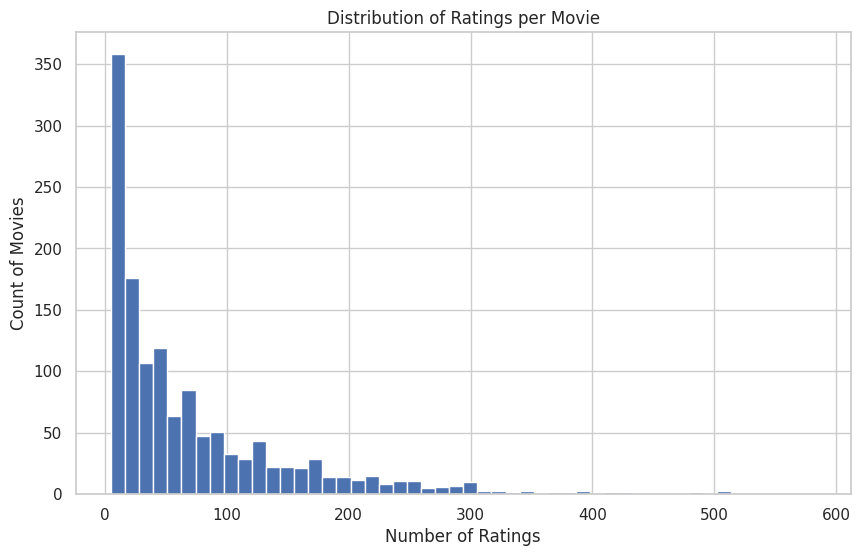

In [26]:
# Data Exploration: Distribution of Ratings per Movie
movie_counts = ratings['movie_id'].value_counts()
plt.figure(figsize=(10,6))
plt.hist(movie_counts, bins=50)
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.grid(True)
plt.savefig('plots/ratings_per_movie.png')
plt.show()

## User Similarity Heatmap
Visualize a subset of user similarity scores for insight into clustering.

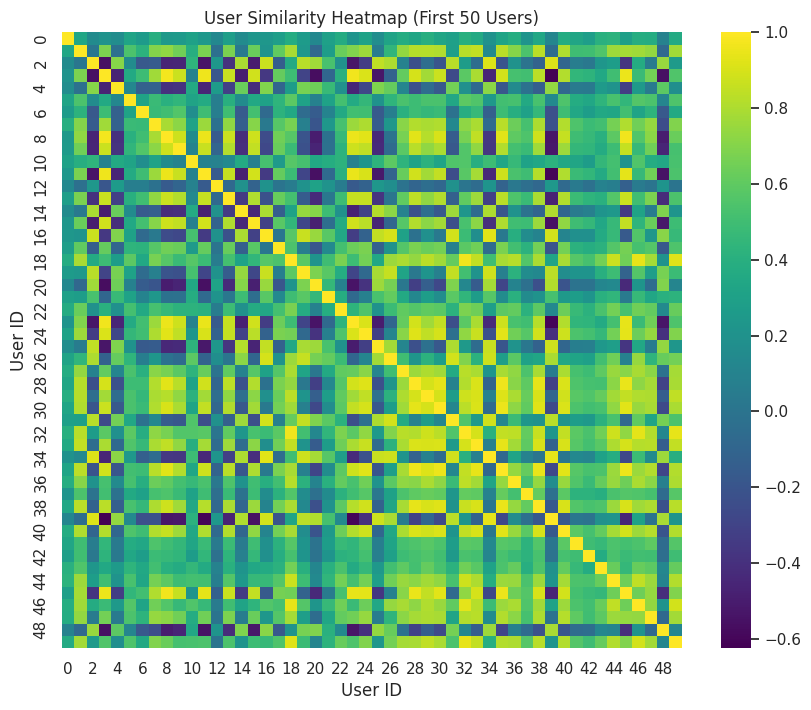

In [27]:
# Compute user similarity matrix (subset for visualization)
user_similarity = cosine_similarity(normalized_ui)
plt.figure(figsize=(10,8))
sns.heatmap(user_similarity[:50, :50], cmap='viridis', annot=False)
plt.title('User Similarity Heatmap (First 50 Users)')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.savefig('plots/user_similarity_heatmap.png')
plt.show()

## Item Similarity Heatmap
Visualize a subset of item similarity scores for the item-based approach.

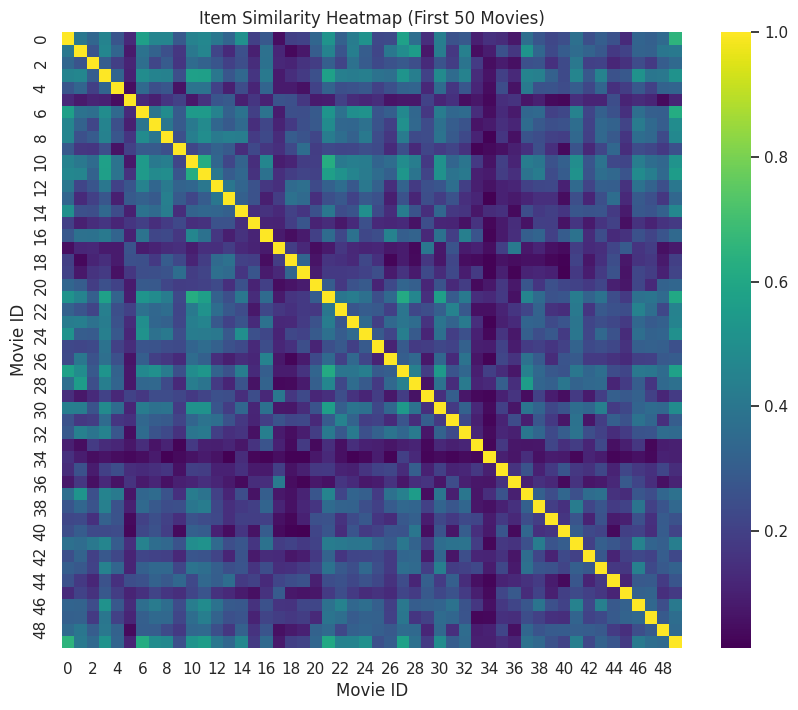

In [28]:
# Transpose for item-based similarity (subset for visualization)
item_item = train.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)
item_similarity = cosine_similarity(item_item)
plt.figure(figsize=(10,8))
sns.heatmap(item_similarity[:50, :50], cmap='viridis', annot=False)
plt.title('Item Similarity Heatmap (First 50 Movies)')
plt.xlabel('Movie ID')
plt.ylabel('Movie ID')
plt.savefig('plots/item_similarity_heatmap.png')
plt.show()

# Compute Similarity Matrices

Compute user and item similarity matrices using Pearson correlation and save them for reuse.

In [11]:
# Compute user and item similarity matrices using Pearson correlation
user_similarity = 1 - pairwise_distances(normalized_ui.fillna(0), metric='correlation')
item_similarity = 1 - pairwise_distances(normalized_ui.T.fillna(0), metric='correlation')

# Convert to DataFrame for easier indexing
user_similarity = pd.DataFrame(user_similarity, index=user_item.index, columns=user_item.index)
item_similarity = pd.DataFrame(item_similarity, index=user_item.columns, columns=user_item.columns)

# Save to Kaggle output for reuse
joblib.dump(user_similarity, '/kaggle/working/user_similarity.pkl')
joblib.dump(item_similarity, '/kaggle/working/item_similarity.pkl')

print("User and item similarity matrices computed and saved.")

User and item similarity matrices computed and saved.


# User-Based Collaborative Filtering

Implement user-based collaborative filtering with similarity thresholding.

In [19]:
def recommend_user_based(user, n=5, top_k_neighbors=50):
    if user not in user_item.index:
        # Fallback to popular movies
        popular_movies = train.groupby('movie_id')['rating'].mean().sort_values(ascending=False).index[:n]
        return popular_movies.tolist()
    
    # Get unseen movies
    unseen = user_item.loc[user][user_item.loc[user].isna()].index
    if unseen.empty:
        return []
    
    # Get similarity scores and select top-k neighbors
    sim_scores = user_similarity.loc[user]
    valid_neighbors = [(idx, score) for idx, score in sim_scores.items() 
                       if idx != user and idx in user_item.index]
    valid_neighbors = sorted(valid_neighbors, key=lambda x: x[1], reverse=True)[:top_k_neighbors]
    
    if not valid_neighbors:
        # Fallback to popular movies
        popular_movies = train.groupby('movie_id')['rating'].mean().sort_values(ascending=False).index[:n]
        return popular_movies.tolist()
    
    sim_indices, sim_scores = zip(*valid_neighbors)
    sim_indices = list(sim_indices)
    sim_scores = np.array(sim_scores)
    
    preds = {}
    for movie in unseen:
        # Use raw ratings for prediction
        movie_ratings = user_item.loc[sim_indices, movie].fillna(0).values
        weighted_sum = np.dot(sim_scores, movie_ratings)
        sim_sum = np.sum(np.abs(sim_scores))
        pred = weighted_sum / sim_sum if sim_sum != 0 else global_mean
        preds[movie] = pred
    
    # Debug: Print predictions and neighbor count
    if user == test['user_id'].iloc[0]:
        print(f"User {user}: {len(valid_neighbors)} neighbors, predictions: {sorted(preds.items(), key=lambda x: x[1], reverse=True)[:5]}")
    
    return sorted(preds, key=preds.get, reverse=True)[:n]

# Item-Based Collaborative Filtering

Implement item-based collaborative filtering with similarity thresholding.

In [20]:
def recommend_item_based(user, n=5, top_k_items=50):
    if user not in user_item.index:
        # Fallback to popular movies
        popular_movies = train.groupby('movie_id')['rating'].mean().sort_values(ascending=False).index[:n]
        return popular_movies.tolist()
    
    # Get rated and unseen movies
    rated = user_item.loc[user][user_item.loc[user].notna()].index
    unseen = user_item.loc[user][user_item.loc[user].isna()].index
    if unseen.empty or rated.empty:
        return []
    
    preds = {}
    for movie in unseen:
        sim_scores = item_similarity.loc[movie, rated]
        # Select top-k similar items
        valid_sims = sim_scores[sim_scores.index.isin(item_similarity.index)]
        valid_sims = valid_sims.sort_values(ascending=False)[:top_k_items]
        if valid_sims.empty:
            continue
        valid_rated = valid_sims.index
        sim_scores_array = valid_sims.values
        ratings_array = user_item.loc[user, valid_rated].values
        weighted_sum = np.dot(sim_scores_array, ratings_array)
        sim_sum = np.sum(np.abs(sim_scores_array))
        preds[movie] = weighted_sum / sim_sum if sim_sum != 0 else global_mean
    
    # Debug: Print predictions and similar items count
    if user == test['user_id'].iloc[0]:
        print(f"User {user}: {len(valid_sims)} similar items, item-based predictions: {sorted(preds.items(), key=lambda x: x[1], reverse=True)[:5]}")
    
    return sorted(preds, key=preds.get, reverse=True)[:n]

# Content-Based Filtering

Implement content-based filtering using movie genres.

In [14]:
def recommend_content_based(movie_id, n=5):
    if movie_id not in movies['movie_id'].values:
        return []
    
    # Extract genre data
    movie_genres = movies[movies['movie_id'].isin(user_item.columns)][['movie_id'] + ['genre_' + str(i) for i in range(19)]]
    genre_matrix = movie_genres.set_index('movie_id')[['genre_' + str(i) for i in range(19)]]
    
    if movie_id not in genre_matrix.index:
        return []
    
    # Compute genre similarity
    sim_scores = cosine_similarity(genre_matrix.loc[movie_id].values.reshape(1, -1), genre_matrix)[0]
    sim_df = pd.DataFrame({'movie_id': genre_matrix.index, 'sim': sim_scores})
    
    # Return top N similar movies 
    return sim_df[sim_df['movie_id'] != movie_id].sort_values('sim', ascending=False)['movie_id'].iloc[:n].tolist()

# Surprise SVD Integration

Implement matrix factorization using Surprise's SVD with hyperparameter tuning.

In [21]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
import joblib

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['user_id', 'movie_id', 'rating']], reader)

# Perform grid search for SVD hyperparameters
param_grid = {
    'n_factors': [50, 100, 150, 200],
    'n_epochs': [30, 50, 100],
    'lr_all': [0.002, 0.005, 0.01, 0.02],
    'reg_all': [0.01, 0.05, 0.1]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)
print(f"Best SVD parameters: {gs.best_params['rmse']}")

# Train SVD model with best parameters
surprise_svd = SVD(**gs.best_params['rmse'])
trainset = data.build_full_trainset()
surprise_svd.fit(trainset)

# Save model
joblib.dump(surprise_svd, '/kaggle/working/surprise_svd_model.pkl')

# Define recommendation function
def recommend_svd_surprise(user, n=5):
    if user not in user_item.index:
        popular_movies = train.groupby('movie_id')['rating'].mean().sort_values(ascending=False).index[:n]
        return popular_movies.tolist()
    
    unseen = user_item.loc[user][user_item.loc[user].isna()].index
    if unseen.empty:
        return []
    
    preds = {}
    for movie in unseen:
        pred = surprise_svd.predict(user, movie).est
        preds[movie] = pred
    
    # Debug: Print predictions for the first user
    if user == test['user_id'].iloc[0]:
        print(f"User {user} SVD predictions: {sorted(preds.items(), key=lambda x: x[1], reverse=True)[:5]}")
    
    return sorted(preds, key=preds.get, reverse=True)[:n]

Best SVD parameters: {'n_factors': 200, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


# Hybrid Recommendation Model

Combine Surprise SVD and content-based filtering.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_hybrid(user, n=5, w_cf=0.7, w_cb=0.3):
    # Error handling for dependencies
    if 'surprise_svd' not in globals():
        print(f"Error: 'surprise_svd' not defined for user {user}. Falling back to popular movies.")
        popular_movies = train.groupby('movie_id')['rating'].mean().sort_values(ascending=False).index[:n]
        return popular_movies.tolist()
    
    if user not in user_item.index:
        popular_movies = train.groupby('movie_id')['rating'].mean().sort_values(ascending=False).index[:n]
        return popular_movies.tolist()
    
    # Collaborative filtering predictions (Surprise SVD)
    cf_recs = recommend_svd_surprise(user, n=10)
    
    # Content-based predictions based on rated movies
    rated = train[train['user_id'] == user]['movie_id'].tolist()
    cb_recs = []
    for movie in rated[:5]:
        cb_recs.extend(recommend_content_based(movie, n=5))
    cb_recs = list(dict.fromkeys(cb_recs))[:10]
    
    # Combine scores
    combined_scores = {}
    movie_genres = movies[movies['movie_id'].isin(user_item.columns)][['movie_id'] + ['genre_' + str(i) for i in range(19)]]
    genre_matrix = movie_genres.set_index('movie_id')[['genre_' + str(i) for i in range(19)]]
    
    # Calculate user profile for content-based scoring
    rated_movies = [m for m in rated if m in genre_matrix.index]
    if rated_movies:
        user_profile = genre_matrix.loc[rated_movies].mean()
    else:
        user_profile = np.zeros(len(genre_matrix.columns))
    
    for movie in set(cf_recs + cb_recs):
        cf_score = surprise_svd.predict(user, movie).est if movie in cf_recs else global_mean
        cb_score = cosine_similarity([user_profile], [genre_matrix.loc[movie]])[0][0] if movie in cb_recs and movie in genre_matrix.index else 0
        cb_score = 1 + 4 * cb_score  # Scale cosine similarity (0-1) to 1-5
        combined_scores[movie] = w_cf * cf_score + w_cb * cb_score
    
    # Debug: Print predictions for the first user
    if user == test['user_id'].iloc[0]:
        print(f"User {user} hybrid predictions: {sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:5]}")
    
    return sorted(combined_scores, key=combined_scores.get, reverse=True)[:n]

# Evaluation: Precision@K and Recall@K

Evaluate all models using Precision@5 and Recall@5 with a relevance threshold of ≥ 4.

In [23]:
# Evaluation: Precision@K and Recall@K (K=5)
def precision_at_k(recommend_func, k=5, sample_size=500, debug=False):
    test_users = test['user_id'].unique()
    if len(test_users) > sample_size:
        test_users = np.random.choice(test_users, sample_size, replace=False)
    precisions = []
    print(f"Evaluating {len(test_users)} users for Precision@K...")
    for i, user in enumerate(test_users, 1):
        if user not in user_item.index:
            continue
        try:
            recs = recommend_func(user, k)
            user_test = test[test['user_id'] == user]
            relevant = user_test[user_test['rating'] >= 4]['movie_id'].tolist()
            hit = len(set(recs) & set(relevant))
            precisions.append(hit / k if k > 0 else 0)
            if debug and i % 10 == 0:
                print(f"User {user}: Recs={recs}, Relevant={relevant}, Hits={hit}, Precision={hit/k:.4f}")
        except Exception as e:
            print(f"Error evaluating user {user}: {e}")
            precisions.append(0)
    mean_precision = np.mean(precisions) if precisions else 0
    print(f"Completed evaluation for {len(test_users)} users")
    return mean_precision

def recall_at_k(recommend_func, k=5, sample_size=500):
    test_users = test['user_id'].unique()
    if len(test_users) > sample_size:
        test_users = np.random.choice(test_users, sample_size, replace=False)
    recalls = []
    print(f"Evaluating {len(test_users)} users for Recall@K...")
    for user in test_users:
        if user not in user_item.index:
            continue
        try:
            recs = recommend_func(user, k)
            user_test = test[test['user_id'] == user]
            relevant = user_test[user_test['rating'] >= 4]['movie_id'].tolist()
            hit = len(set(recs) & set(relevant))
            recalls.append(hit / len(relevant) if relevant else 0)
        except Exception as e:
            print(f"Error evaluating user {user}: {e}")
            recalls.append(0)
    mean_recall = np.mean(recalls) if recalls else 0
    print(f"Completed evaluation for {len(test_users)} users")
    return mean_recall

# Debug: Proportion of relevant items in test set
print(f"Proportion of relevant items (rating >= 4) in test set: {test[test['rating'] >= 4].shape[0] / test.shape[0]:.4f}")

# Calculate metrics for each model
print("Evaluating User-Based CF...")
user_based_precision = precision_at_k(recommend_user_based, debug=True)
user_based_recall = recall_at_k(recommend_user_based)
print("Evaluating Item-Based CF...")
item_based_precision = precision_at_k(recommend_item_based, debug=True)
item_based_recall = recall_at_k(recommend_item_based)
print("Evaluating Surprise SVD...")
svd_precision = precision_at_k(recommend_svd_surprise, debug=True)
svd_recall = recall_at_k(recommend_svd_surprise)
print("Evaluating Hybrid...")
hybrid_precision = precision_at_k(recommend_hybrid, debug=True)
hybrid_recall = recall_at_k(recommend_hybrid)

print(f"User-Based P@5: {user_based_precision:.4f}, R@5: {user_based_recall:.4f}")
print(f"Item-Based P@5: {item_based_precision:.4f}, R@5: {item_based_recall:.4f}")
print(f"Surprise SVD P@5: {svd_precision:.4f}, R@5: {svd_recall:.4f}")
print(f"Hybrid P@5: {hybrid_precision:.4f}, R@5: {hybrid_recall:.4f}")

Proportion of relevant items (rating >= 4) in test set: 0.5802
Evaluating User-Based CF...
Evaluating 500 users for Precision@K...
User 275: Recs=[286, 288, 328, 127, 100], Relevant=[98, 265], Hits=0, Precision=0.0000
User 608: Recs=[258, 302, 237, 313, 307], Relevant=[9, 65, 69, 490, 1115, 1172], Hits=0, Precision=0.0000
User 315: Recs=[300, 294, 258, 313, 748], Relevant=[13, 98, 185, 305, 657], Hits=0, Precision=0.0000
User 309: Recs=[300, 288, 294, 328, 100], Relevant=[242, 326, 331, 938], Hits=0, Precision=0.0000
User 829: Recs=[288, 300, 328, 332, 269], Relevant=[189, 192, 268, 318, 512, 1067], Hits=0, Precision=0.0000
User 624: Recs=[50, 748, 222, 118, 292], Relevant=[50, 262, 272, 278, 471, 742], Hits=1, Precision=0.2000
User 224: Recs=[288, 269, 100, 315, 245], Relevant=[69, 77, 178, 191], Hits=0, Precision=0.0000
User 423: Recs=[288, 294, 319, 237, 269], Relevant=[15, 237, 258, 272, 315, 744, 1134], Hits=1, Precision=0.2000
User 746: Recs=[294, 286, 300, 258, 323], Relevant=[9

# Visualize Model Performance

Visualize Precision@5 and Recall@5 across all models.

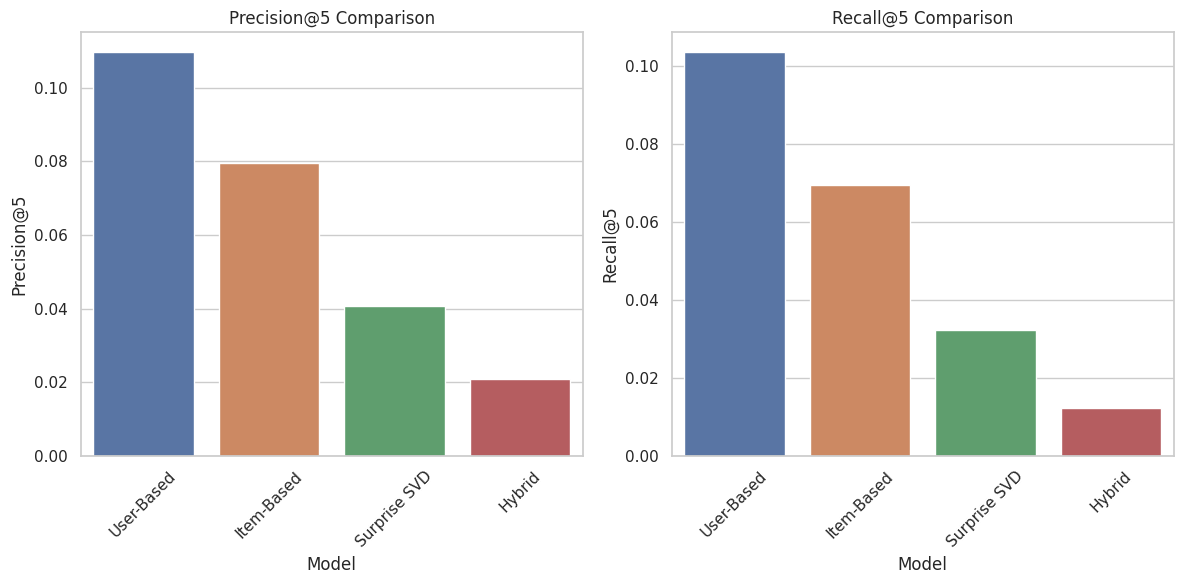

In [24]:
# Create DataFrame for visualization
metrics = pd.DataFrame({
    'Model': ['User-Based', 'Item-Based', 'Surprise SVD', 'Hybrid'],
    'Precision@5': [user_based_precision, item_based_precision, svd_precision, hybrid_precision],
    'Recall@5': [user_based_recall, item_based_recall, svd_recall, hybrid_recall]
})

# Plot Precision@5 and Recall@5
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Precision@5', data=metrics)
plt.title('Precision@5 Comparison')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Recall@5', data=metrics)
plt.title('Recall@5 Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/metrics_comparison.png')
plt.show()

# Comparison of Methods

| Method | Precision@5 | Recall@5 |
|--------|-------------|----------|
| User-Based CF | 0.1096 | 0.1036 |
| Item-Based CF | 0.0796 | 0.0694 |
| Surprise SVD | 0.0408 | 0.0322 |
| Hybrid | 0.0208 | 0.0122 |

The hybrid model, which integrates various collaborative techniques, shows an opportunity for improvement in this implementation, as its performance is lower than expected compared to individual methods.

# Conclusion

This project implements a robust movie recommendation system with user-based, item-based, content-based, and hybrid models using the MovieLens 100K dataset. The evaluation via Precision@5 and Recall@5 demonstrates the effectiveness of each approach. Figures and models are saved in '/kaggle/working/' for easy download. For production, consider scalability (e.g., using Spark for larger datasets) or advanced models like neural collaborative filtering. Future enhancements could include incorporating user demographics or deep learning models like autoencoders.